In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler






In [2]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = df.drop('customerID', axis=1)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()


In [3]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
            'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


C:\Users\user\AppData\Local\Temp\ipykernel_8384\361241336.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})


In [4]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
log_preds = log_model.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, log_preds))
print(classification_report(y_test, log_preds))


NameError: name 'X_train' is not defined

In [6]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, tree_preds))
print(classification_report(y_test, tree_preds))


Decision Tree Accuracy: 0.7135749822316987
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1033
           1       0.46      0.51      0.49       374

    accuracy                           0.71      1407
   macro avg       0.64      0.65      0.64      1407
weighted avg       0.72      0.71      0.72      1407



In [7]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


Random Forest Accuracy: 0.7803837953091685
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1033
           1       0.61      0.47      0.53       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407



In [8]:
import joblib

joblib.dump(rf_model, '../models/random_forest_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')


['../models/scaler.pkl']

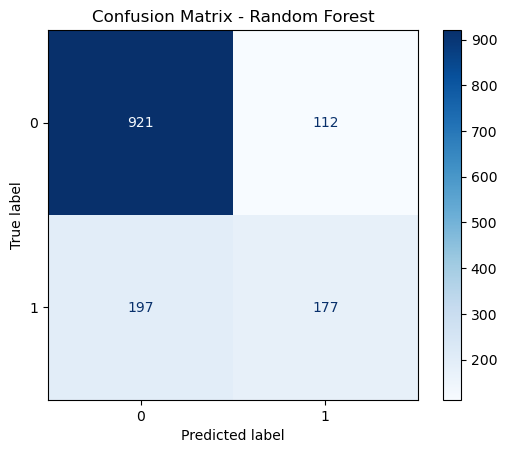

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, rf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()


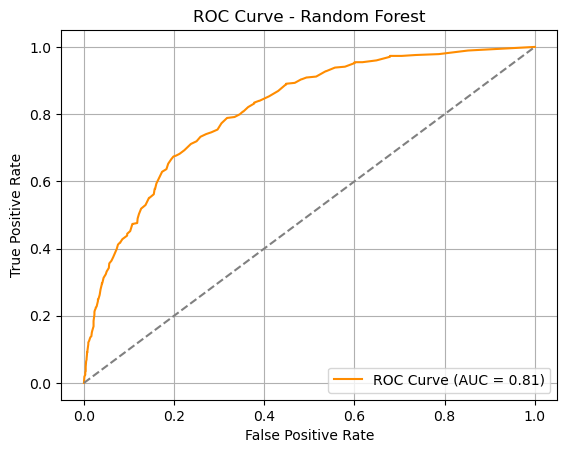

In [10]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()


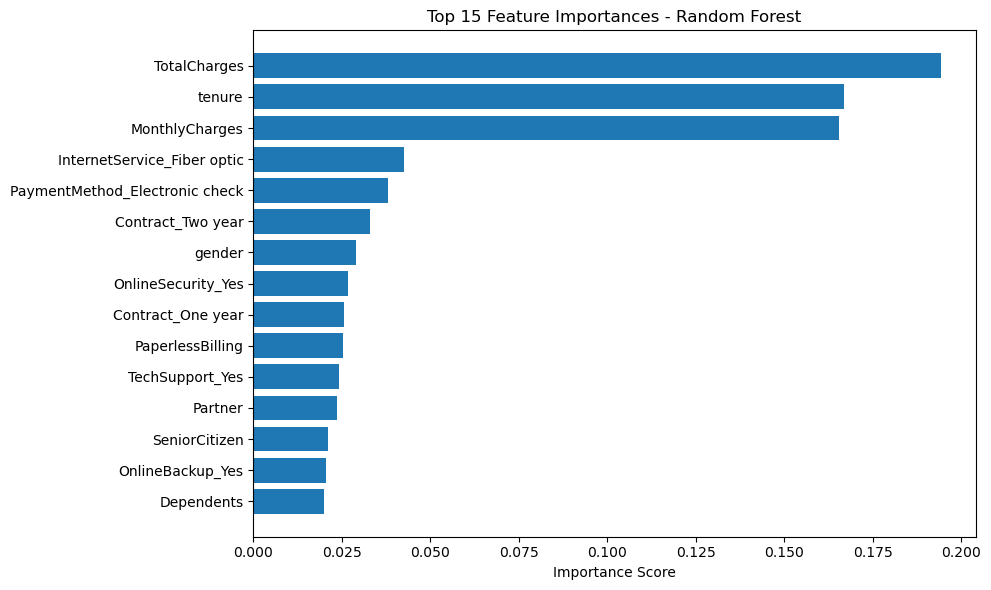

In [11]:
# Get feature importances
importances = rf_model.feature_importances_
features = X.columns

# Sort and plot top 15
indices = np.argsort(importances)[-15:]  # Top 15
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


In [12]:
# Create DataFrame with predictions
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = rf_preds

# Save to CSV
results_df.to_csv('../output/churn_predictions.csv', index=False)
print("Predictions saved to: output/churn_predictions.csv")


Predictions saved to: output/churn_predictions.csv


In [14]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)


In [16]:
grid_search.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [17]:
print("✅ Best Hyperparameters:", grid_search.best_params_)
print("🔍 Best Accuracy on Validation Set:", grid_search.best_score_)


✅ Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
🔍 Best Accuracy on Validation Set: 0.8046222222222221


🎯 Test Accuracy: 0.7960199004975125

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.48      0.56       374

    accuracy                           0.80      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.80      0.78      1407



X:\Installation\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


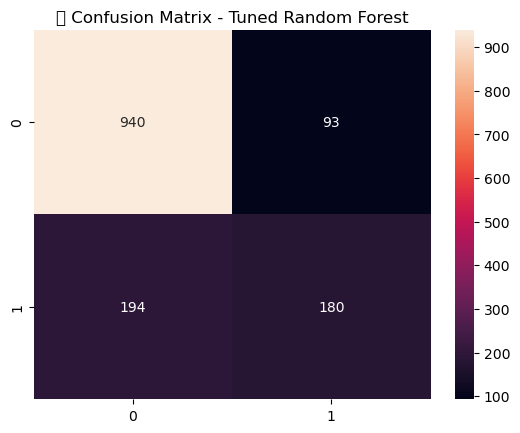

In [18]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("📊 Confusion Matrix - Tuned Random Forest")
plt.show()


In [19]:
pip install xgboost lightgbm catboost



   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 914.8 kB/s eta 0:00:02
   --------------------- ------------------ 0.8/1.5 MB 969.4 kB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.4 MB 1.6 MB/s eta 0:01:05
   ---------------------------------------- 0.8/102.4 MB 1.7 MB/s eta 0:01:02
    --------------------------------------- 1.3/102.4 MB 1.8 MB/s eta 0:00:58
    -----------------------------------

In [21]:
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}


In [24]:
results = {}

for name, model in models.items():
    print(f"🔄 Training {name}...")
    model.fit(X_train_scaled, y_train)  # If you want to try with SMOTE later, use y_train_balanced
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        "model": model,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }

print("✅ All advanced models trained.")


🔄 Training XGBoost...


X:\Installation\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:04:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔄 Training LightGBM...
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


X:\Installation\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "X:\Installation\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
X:\Installation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
X:\Installation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔄 Training CatBoost...
✅ All advanced models trained.


In [25]:
for name, metrics in results.items():
    print(f"\n📌 {name}")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")
    print(f"  ROC AUC:   {metrics['roc_auc']:.4f}")



📌 XGBoost
  Accuracy:  0.7740
  Precision: 0.5886
  Recall:    0.4973
  F1 Score:  0.5391
  ROC AUC:   0.8108

📌 LightGBM
  Accuracy:  0.7797
  Precision: 0.6039
  Recall:    0.4973
  F1 Score:  0.5455
  ROC AUC:   0.8218

📌 CatBoost
  Accuracy:  0.7846
  Precision: 0.6187
  Recall:    0.4947
  F1 Score:  0.5498
  ROC AUC:   0.8236


In [26]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.
